In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp

# import warnings filter
import warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
pd.options.mode.chained_assignment = None 

# Loading Initial Dataset

In [60]:
df = pd.read_csv('df2015_complete.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df

,w_regn,w_id,w_shsn,w_hcn,rfact,toinc_decile,pcinc_decile,reg_pcdecile,fsize,pcinc,...,ref_qty,wash_qty,aircon_qty,car_qty,landline_qty,cellphone_qty,pc_qty,oven_qty,motor_banca_qty,motorcycle_qty
0,14,101008000,1,8,211.1572,9,9,9,4.0,120083.00,...,1.0,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,1.0
1,14,101008000,2,19,211.1572,6,7,7,3.0,66078.33,...,NaN,1.0,NaN,NaN,NaN,3.0,1.0,NaN,NaN,2.0
2,14,101008000,3,31,211.1572,2,1,1,6.0,13797.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14,101008000,4,42,211.1572,3,3,2,4.5,23908.67,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,14,101008000,5,54,211.1572,6,6,5,4.0,47330.50,...,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41539,12,9804035000,1,6,392.6993,3,2,3,6.5,18426.62,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41540,12,9804035000,2,33,392.6993,4,2,4,6.0,22886.67,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
41541,12,9804035000,3,58,392.6993,4,4,6,4.0,33292.75,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41542,12,9804035000,4,83,392.6993,4,1,2,9.0,14388.89,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


# Creating Dictionaries for Reference

In [61]:
data_dict = pd.read_csv('fies2015_datadictionary.csv', names = ['col_name','new_name'],)[1:]
data_dict.reset_index(inplace = True)
data_dict.drop(data_dict.columns[0], inplace = True, axis = 1)
data_dict = {k:v for k,v in zip(data_dict[data_dict.columns[0]],
                    data_dict[data_dict.columns[1]])} 
data_dict_r = {v:k for k,v in data_dict.items()}

In [263]:
W_REGN= {
    1: 'I - Ilocos Region',
    2: 'II - Cagayan Valley',
    3: 'III - Central Luzon',
    5: 'V - Bicol Region',
    6: 'VI - Western Visayas',
    7: 'VII - Central Visayas',
    8: 'VIII - Eastern Visayas',
    9: 'IX - Zasmboanga Peninsula',
    10: 'X - Northern Mindanao',
    11: 'XI - Davao Region',
    12: 'XII - SOCCSKSARGEN',
    13: 'NCR',
    14: 'CAR',
    15: 'ARMM',
    16: 'Caraga',
    41: 'IVA - CALABARZON',
    42: 'IVB - MIMAROPA'
}

In [264]:
import pyreadstat
fp2015 = 'FIES2015Complete.dta'
df2015, meta2015 = pyreadstat.read_dta(fp2015)
def get_meta(col_str):
    '''Retrieves mapping of values from FIES Metadata'''
    query = str.upper(col_str)
    return meta2015.value_labels[query]

# Defining Statistical Functions

In [265]:
def test_for_normality(data):
    from scipy.stats import shapiro
    stat, p = shapiro(data)
    #print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        result = 'is probably Gaussian per Shapiro-Wilk Test'
    else:
        result = 'is probably NOT Gaussian per Shapiro-Wilk Test'
    return result

In [266]:
def test_for_signif_diff(data1, data2, normal=False, test = 'mann-whitney'):
    if normal:
        from scipy.stats import ttest_ind
        stat, p = ttest_ind(data1, data2)
        
        if p > 0.05:
            result = f'is probably statistically different per T-Test'
        else:
            result = f'is probably NOT statistically different per T-Test'
        return result
        
    elif not normal:
        from scipy.stats import kruskal
        from scipy.stats import mannwhitneyu
        stat, p1 = kruskal(data1, data2)
        stat, p2 = mannwhitneyu(data1, data2)
        
        if test == 'mann-whitney':
            p = p2
        elif test == 'kruskal-wallis':
            p = p1
            
        if p > 0.05:
            result = f'is probably statistically different per {test}'
        else:
            result = f'is probably NOT statistically different per {test}'
        return result

# Data Wrangling and Preprocessing

## Limiting Data to Single and One-man Households

In [267]:
bachelors = df[(df.fsize == 1) & (df.ms == 1)]

## Health and Wellbeing

In [331]:
med_cols = [
    'tmedprep',
    'tmedpharm',
    'tmednutri',
]

medservice_cols = [
    'tmedgeneral',
    'tmedspecial',
    'tdental'
]

otherhw_cols = [
    'tmiscpershair',
    'tmiscinsurance',
]

In [332]:
med_products = bachelors[med_cols].sum(axis = 1)
med_services = bachelors[medservice_cols].sum(axis = 1)
hw_misc = bachelors[otherhw_cols].sum(axis = 1)

In [333]:
df_hw = bachelors[['w_regn','sex','ttotex']]
df_hw['med_products'] = med_products
df_hw['med_products_pcntg'] = med_products/df_hw.ttotex
df_hw['med_services'] = med_services
df_hw['med_services_pcntg'] = med_services/df_hw.ttotex
df_hw['hw_misc'] = hw_misc 
df_hw['hw_misc_pcntg'] = hw_misc/df_hw.ttotex
df_hw

,w_regn,sex,ttotex,med_products,med_products_pcntg,med_services,med_services_pcntg,hw_misc,hw_misc_pcntg
77,14,1,59965.0,120,0.002001,0,0.000000,300,0.005003
197,14,2,32430.0,260,0.008017,0,0.000000,102,0.003145
214,14,2,80280.0,440,0.005481,0,0.000000,300,0.003737
251,14,1,37654.0,70,0.001859,0,0.000000,600,0.015935
257,14,1,39972.0,100,0.002502,0,0.000000,600,0.015011
...,...,...,...,...,...,...,...,...,...
41023,11,1,49671.0,0,0.000000,0,0.000000,360,0.007248
41024,11,1,75984.0,0,0.000000,5000,0.065803,390,0.005133
41321,9,1,56456.0,1084,0.019201,0,0.000000,1800,0.031883
41435,9,1,121491.0,7876,0.064828,1500,0.012347,390,0.003210


However, from initial inspection of the Health and Wellbeing DataFrame our team had noticed that there were a limited number of correspondents that availed of medical services. Figure N, shows the total number of people that availed of these services per region. 

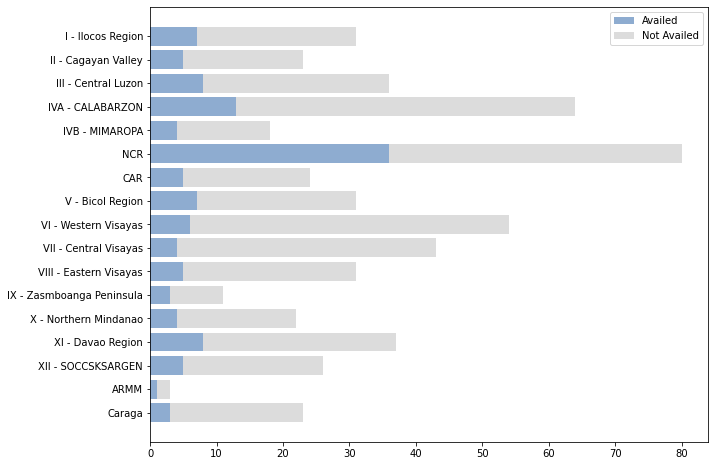

In [363]:
total_members = df_hw.groupby(['w_regn']).med_services.count()
med_service_df = pd.DataFrame({'Availed':availed_services,
                               'Members':total_members}).reset_index()
med_service_df['w_regn'] = med_service_df['w_regn'].map(W_REGN)

sorter = [
    'I - Ilocos Region',
    'II - Cagayan Valley',
    'III - Central Luzon',
    'IVA - CALABARZON',
    'IVB - MIMAROPA',
    'NCR',
    'CAR',
    'V - Bicol Region',
    'VI - Western Visayas',
    'VII - Central Visayas',
    'VIII - Eastern Visayas',
    'IX - Zasmboanga Peninsula',
    'X - Northern Mindanao',
    'XI - Davao Region',
    'XII - SOCCSKSARGEN',
    'ARMM',
    'Caraga',
]
sorterIndex = dict(zip(sorter, range(len(sorter))))
med_service_df['Tm_Rank'] = med_service_df['w_regn'].map(sorterIndex)
med_service_df.sort_values('Tm_Rank', ascending = False, inplace = True)

width = 0.3
fig, ax = plt.subplots(figsize = (10,8))
ax.barh(med_service_df['w_regn'],
        med_service_df['Availed'],
        zorder = 2, label = 'Availed',
        color = '#8eacd0')
ax.barh(med_service_df['w_regn'],
        med_service_df['Members'],
        label = 'Not Availed',
        color = 'gainsboro')
plt.legend()
pass

### High-Level

#### Checking for Normality

In [335]:
df_hw = df_hw.copy()
print(len(df_hw))
for p in pcntg_cols:
    df_hw = df_hw[df_hw[p] != 0]
print(len(df_hw))

737
557


In [336]:
pcntg_cols = ['med_products_pcntg',
              #'med_services_pcntg',
              'hw_misc_pcntg']
for pc in pcntg_cols:
    print(pc,test_for_normality(df_hw[pc]))

med_products_pcntg is probably NOT Gaussian per Shapiro-Wilk Test
hw_misc_pcntg is probably NOT Gaussian per Shapiro-Wilk Test


#### Looking at Difference with respect to Sex

In [344]:
for pc in pcntg_cols:
    male = np.log(df_hw[df_hw.sex == 1][pc])
    female = np.log(df_hw[df_hw.sex == 2][pc])
    print(pc,test_for_signif_diff(male, female))

med_products_pcntg is probably NOT statistically different per mann-whitney
hw_misc_pcntg is probably statistically different per mann-whitney


In [345]:
df_hw.groupby('sex')['med_products_pcntg',
                     'hw_misc_pcntg'].mean()

,med_products_pcntg,hw_misc_pcntg
sex,,
1,0.018565,0.015401
2,0.061428,0.024497


### Per Region

#### Checking for Normality

In [392]:
df_hw_reg_norm = pd.DataFrame()
df_hw_reg_norm['Regn'] = sorted(set(df_hw.w_regn))
df_hw_reg_norm['Regn'] = df_hw_reg_norm['Regn'].map(W_REGN)
pcntg_cols = ['med_products_pcntg', 'hw_misc_pcntg']
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_hw.w_regn)):
        df_reg = df_hw[df_hw['w_regn'] == rgn]
        test = test_for_normality(df_reg[pc])
        if 'NOT' in test:
            test_vals.append('NOT Gaussian')
        else:
            test_vals.append('Gaussian')
    df_hw_reg_norm[pc] = test_vals
df_hw_reg_norm

,Regn,med_products_pcntg,hw_misc_pcntg
0,I - Ilocos Region,NOT Gaussian,NOT Gaussian
1,II - Cagayan Valley,NOT Gaussian,NOT Gaussian
2,III - Central Luzon,NOT Gaussian,NOT Gaussian
3,V - Bicol Region,NOT Gaussian,NOT Gaussian
4,VI - Western Visayas,NOT Gaussian,NOT Gaussian
5,VII - Central Visayas,NOT Gaussian,NOT Gaussian
6,VIII - Eastern Visayas,NOT Gaussian,NOT Gaussian
7,IX - Zasmboanga Peninsula,NOT Gaussian,NOT Gaussian
8,X - Northern Mindanao,NOT Gaussian,NOT Gaussian
9,XI - Davao Region,NOT Gaussian,NOT Gaussian


#### Looking at Difference with respect to Sex

In [349]:
df_hw_reg_diff = pd.DataFrame()
df_hw_reg_diff['Regn'] = sorted(set(df_hw.w_regn))
df_hw_reg_diff['Regn'] = df_hw_reg_diff['Regn'].map(W_REGN)
pcntg_cols = ['med_products_pcntg', 'hw_misc_pcntg']
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_hw.w_regn)):
        df_reg = df_hw[df_hw['w_regn'] == rgn]
        if 'NOT' in test_for_normality(df_reg[pc]):
            normal = False
        else:
            normal = True
        male = df_reg[df_reg.sex == 1][pc]
        female = df_reg[df_reg.sex == 2][pc]
        test = test_for_signif_diff(male, female, normal)
        if 'NOT' in test:
            test_vals.append('NOT significant')
        else:
            test_vals.append('Significant')
    df_hw_reg_diff[pc] = test_vals
df_hw_reg_diff

,Regn,med_products_pcntg,hw_misc_pcntg
0,I - Ilocos Region,Significant,Significant
1,II - Cagayan Valley,Significant,NOT significant
2,III - Central Luzon,Significant,Significant
3,V - Bicol Region,Significant,Significant
4,VI - Western Visayas,NOT significant,NOT significant
5,VII - Central Visayas,Significant,Significant
6,VIII - Eastern Visayas,NOT significant,Significant
7,IX - Zasmboanga Peninsula,Significant,Significant
8,X - Northern Mindanao,NOT significant,Significant
9,XI - Davao Region,NOT significant,Significant


## Misc. Expenses

In [126]:
specoc_cols = [
    'tfoodspec',
    'talcospec',
    'tservicespec',
]

gadget_cols = [
    'tcellphone',
    'tsingalong',
    'tcameras',
    'tpc',
    'tnotebook',
]

nongadget_cols = [
    'tcgarment',
    'tfootwear',
    'tmiscjewelry',
]

In [127]:
spec_expense = bachelors[specoc_cols].sum(axis = 1)
gadget_expense = bachelors[gadget_cols].sum(axis = 1)
fashion_misc = bachelors[nongadget_cols].sum(axis = 1)

In [128]:
df_misc = bachelors[['w_regn','sex','ttotex']]
df_misc['spec_expense'] = spec_expense
df_misc['spec_expense_pcntg'] = spec_expense/df_misc.ttotex
df_misc['gadget_expense'] = gadget_expense
df_misc['gadget_expense_pcntg'] = gadget_expense/df_misc.ttotex
df_misc['fashion_misc'] = fashion_misc 
df_misc['fashion_misc_pcntg'] = fashion_misc/df_misc.ttotex
df_misc

,w_regn,sex,ttotex,spec_expense,spec_expense_pcntg,gadget_expense,gadget_expense_pcntg,fashion_misc,fashion_misc_pcntg
77,14,1,59965.0,500,0.008338,0,0.000000,600,0.010006
197,14,2,32430.0,0,0.000000,0,0.000000,1220,0.037619
214,14,2,80280.0,1000,0.012456,0,0.000000,950,0.011834
251,14,1,37654.0,0,0.000000,0,0.000000,450,0.011951
257,14,1,39972.0,0,0.000000,0,0.000000,200,0.005004
...,...,...,...,...,...,...,...,...,...
41023,11,1,49671.0,4000,0.080530,0,0.000000,2710,0.054559
41024,11,1,75984.0,8000,0.105285,0,0.000000,4440,0.058433
41321,9,1,56456.0,0,0.000000,0,0.000000,3240,0.057390
41435,9,1,121491.0,34000,0.279856,2000,0.016462,850,0.006996


### High-Level

#### Checking for Normality

In [350]:
pcntg_cols = ['spec_expense_pcntg', 'gadget_expense_pcntg', 'fashion_misc_pcntg']
for pc in pcntg_cols:
    print(pc,test_for_normality(df_misc[pc]))

spec_expense_pcntg is probably NOT Gaussian per Shapiro-Wilk Test
gadget_expense_pcntg is probably NOT Gaussian per Shapiro-Wilk Test
fashion_misc_pcntg is probably NOT Gaussian per Shapiro-Wilk Test


#### Looking at Difference with respect to Sex

In [351]:
pcntg_cols = ['spec_expense_pcntg', 'gadget_expense_pcntg', 'fashion_misc_pcntg']
for pc in pcntg_cols:
    male = df_misc[df_misc.sex == 1][pc]
    female = df_misc[df_misc.sex == 2][pc]
    print(pc,test_for_signif_diff(male, female))

spec_expense_pcntg is probably statistically different per mann-whitney
gadget_expense_pcntg is probably statistically different per mann-whitney
fashion_misc_pcntg is probably NOT statistically different per mann-whitney


In [352]:
pcntg_cols = ['spec_expense_pcntg', 'gadget_expense_pcntg', 'fashion_misc_pcntg']
df_misc.groupby('sex')[pcntg_cols].mean()

,spec_expense_pcntg,gadget_expense_pcntg,fashion_misc_pcntg
sex,,,
1,0.010638,0.004315,0.028974
2,0.010154,0.004467,0.021850


### Per Region

#### Checking for Normality

In [353]:
df_misc_reg_norm = pd.DataFrame()
df_misc_reg_norm['Regn'] = sorted(set(df_misc.w_regn))
df_misc_reg_norm['Regn'] = df_misc_reg_norm['Regn'].map(W_REGN)
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_misc.w_regn)):
        df_reg = df_misc[df_misc['w_regn'] == rgn]
        test = test_for_normality(df_reg[pc])
        if 'NOT' in test:
            test_vals.append('NOT Gaussian')
        else:
            test_vals.append('Gaussian')
    df_misc_reg_norm[pc] = test_vals
df_misc_reg_norm

/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Regn,spec_expense_pcntg,gadget_expense_pcntg,fashion_misc_pcntg
0,I - Ilocos Region,NOT Gaussian,NOT Gaussian,NOT Gaussian
1,II - Cagayan Valley,NOT Gaussian,NOT Gaussian,NOT Gaussian
2,III - Central Luzon,NOT Gaussian,NOT Gaussian,NOT Gaussian
3,V - Bicol Region,NOT Gaussian,Gaussian,NOT Gaussian
4,VI - Western Visayas,NOT Gaussian,NOT Gaussian,NOT Gaussian
5,VII - Central Visayas,NOT Gaussian,NOT Gaussian,NOT Gaussian
6,VIII - Eastern Visayas,NOT Gaussian,NOT Gaussian,NOT Gaussian
7,IX - Zasmboanga Peninsula,NOT Gaussian,NOT Gaussian,NOT Gaussian
8,X - Northern Mindanao,NOT Gaussian,NOT Gaussian,NOT Gaussian
9,XI - Davao Region,NOT Gaussian,NOT Gaussian,NOT Gaussian


#### Looking at Difference with respect to Sex

In [354]:
df_misc_reg_diff = pd.DataFrame()
df_misc_reg_diff['Regn'] = sorted(set(df_misc.w_regn))
df_misc_reg_diff['Regn'] = df_misc_reg_diff['Regn'].map(W_REGN)
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_misc.w_regn)):
        df_reg = df_misc[df_misc['w_regn'] == rgn]
        if 'NOT' in test_for_normality(df_reg[pc]):
            normal = False
        else:
            normal = True
        male = df_reg[df_reg.sex == 1][pc]
        female = df_reg[df_reg.sex == 2][pc]
        test = test_for_signif_diff(male, female, normal)
        if 'NOT' in test:
            test_vals.append('NOT significant')
        else:
            test_vals.append('Significant')
    df_misc_reg_diff[pc] = test_vals
df_misc_reg_diff

/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Regn,spec_expense_pcntg,gadget_expense_pcntg,fashion_misc_pcntg
0,I - Ilocos Region,Significant,Significant,Significant
1,II - Cagayan Valley,Significant,Significant,Significant
2,III - Central Luzon,Significant,Significant,Significant
3,V - Bicol Region,Significant,NOT significant,Significant
4,VI - Western Visayas,Significant,Significant,Significant
5,VII - Central Visayas,Significant,Significant,NOT significant
6,VIII - Eastern Visayas,Significant,Significant,NOT significant
7,IX - Zasmboanga Peninsula,Significant,Significant,Significant
8,X - Northern Mindanao,NOT significant,Significant,Significant
9,XI - Davao Region,Significant,Significant,Significant


## Impersonal Expenses

### High-Level

In [157]:
donations_cols = [
    'toassist',
    'toreligious',
    'tootherinst',
]

In [158]:
donations_expense = bachelors[donations_cols].sum(axis = 1)

In [159]:
df_impr = bachelors[['w_regn','sex','ttotex']]
df_impr['donations_expense'] = donations_expense
df_impr['donations_expense_pcntg'] = donations_expense/df_impr.ttotex
df_impr

,w_regn,sex,ttotex,donations_expense,donations_expense_pcntg
77,14,1,59965.0,150,0.002501
197,14,2,32430.0,50,0.001542
214,14,2,80280.0,240,0.002990
251,14,1,37654.0,0,0.000000
257,14,1,39972.0,0,0.000000
...,...,...,...,...,...
41023,11,1,49671.0,0,0.000000
41024,11,1,75984.0,12000,0.157928
41321,9,1,56456.0,0,0.000000
41435,9,1,121491.0,0,0.000000


#### Checking for Normality

In [161]:
pcntg_cols = ['donations_expense_pcntg']
for pc in pcntg_cols:
    print(pc,test_for_normality(df_impr[pc]))

donations_expense_pcntg is probably NOT Gaussian per Shapiro-Wilk Test


#### Looking at Difference with respect to Sex

In [163]:
for pc in pcntg_cols:
    male = df_impr[df_impr.sex == 1][pc]
    female = df_impr[df_impr.sex == 2][pc]
    print(pc,test_for_signif_diff(male, female))

donations_expense_pcntg is probably NOT statistically different per mann-whitney


In [164]:
pcntg_cols = ['donations_expense_pcntg']
df_impr.groupby('sex')[pcntg_cols].mean()

,donations_expense_pcntg
sex,
1,0.020453
2,0.022881


### Per Region

#### Checking for Normality

In [165]:
df_impr_reg_norm = pd.DataFrame()
df_impr_reg_norm['Regn'] = sorted(set(df_impr.w_regn))
df_impr_reg_norm['Regn'] = df_impr_reg_norm['Regn'].map(W_REGN)
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_impr.w_regn)):
        df_reg = df_impr[df_impr['w_regn'] == rgn]
        test = test_for_normality(df_reg[pc])
        if 'NOT' in test:
            test_vals.append('NOT Gaussian')
        else:
            test_vals.append('Gaussian')
    df_impr_reg_norm[pc] = test_vals
df_impr_reg_norm

,Regn,donations_expense_pcntg
0,I - Ilocos Region,NOT Gaussian
1,II - Cagayan Valley,NOT Gaussian
2,III - Central Luzon,NOT Gaussian
3,V - Bicol Region,NOT Gaussian
4,VI - Western Visayas,NOT Gaussian
5,VII - Central Visayas,NOT Gaussian
6,VIII - Eastern Visayas,NOT Gaussian
7,IX - Zasmboanga Peninsula,NOT Gaussian
8,X - Northern Mindanao,NOT Gaussian
9,XI - Davao Region,NOT Gaussian


#### Looking at Difference with respect to Sex

In [166]:
df_impr_reg_diff = pd.DataFrame()
df_impr_reg_diff['Regn'] = sorted(set(df_impr.w_regn))
df_impr_reg_diff['Regn'] = df_impr_reg_diff['Regn'].map(W_REGN)
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_impr.w_regn)):
        df_reg = df_impr[df_impr['w_regn'] == rgn]
        if 'NOT' in test_for_normality(df_reg[pc]):
            normal = False
        else:
            normal = True
        male = df_reg[df_reg.sex == 1][pc]
        female = df_reg[df_reg.sex == 2][pc]
        test = test_for_signif_diff(male, female, normal)
        if 'NOT' in test:
            test_vals.append('NOT significant')
        else:
            test_vals.append('Significant')
    df_impr_reg_diff[pc] = test_vals
df_impr_reg_diff

,Regn,donations_expense_pcntg
0,I - Ilocos Region,Significant
1,II - Cagayan Valley,Significant
2,III - Central Luzon,Significant
3,V - Bicol Region,Significant
4,VI - Western Visayas,Significant
5,VII - Central Visayas,NOT significant
6,VIII - Eastern Visayas,Significant
7,IX - Zasmboanga Peninsula,NOT significant
8,X - Northern Mindanao,NOT significant
9,XI - Davao Region,Significant


# Vizzes

## Bar Plots

### Health and Wellbeing

#### Entire

In [524]:
pcntg_cols = ['med_products_pcntg',
              'hw_misc_pcntg']
for pc in pcntg_cols:
    male = df_hw[df_hw.sex == 1][pc]
    female = df_hw[df_hw.sex == 2][pc]
    print(pc,test_for_signif_diff(male, female))

med_products_pcntg is probably NOT statistically different per mann-whitney
hw_misc_pcntg is probably statistically different per mann-whitney


In [521]:
df_hw_entire = df_hw.groupby('sex')['med_products_pcntg',
                     'hw_misc_pcntg'].mean().reset_index().melt(id_vars=['sex'])
df_hw_entire

,sex,variable,value
0,1,med_products_pcntg,0.018565
1,2,med_products_pcntg,0.061428
2,1,hw_misc_pcntg,0.015401
3,2,hw_misc_pcntg,0.024497


In [558]:
df_hw_entire.to_csv('df_hw_entire.csv',index = False)

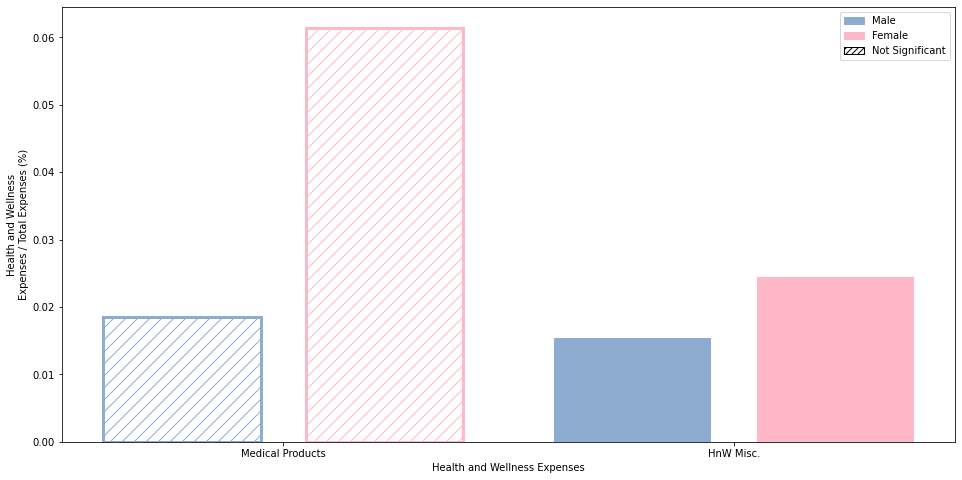

In [577]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = df_hw_entire[df_hw_entire.sex == 1]
df_f = df_hw_entire[df_hw_entire.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.value, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.value, width, label = 'Women')
ax.set(xticks=x, xticklabels=['Medical Products', 'HnW Misc.'])
signif = ['NOT significant', 'Significant']
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")
        
plt.ylabel('Health and Wellness\nExpenses / Total Expenses (%)')
plt.xlabel('Health and Wellness Expenses')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

["#8eacd0", "#ffb8c7"]

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass

#### Per Region

In [559]:
df_hw_reg_diff = pd.DataFrame()
df_hw_reg_diff['Regn'] = sorted(set(df_hw.w_regn))
df_hw_reg_diff['Regn'] = df_hw_reg_diff['Regn'].map(W_REGN)
pcntg_cols = ['med_products_pcntg', 'hw_misc_pcntg']
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_hw.w_regn)):
        df_reg = df_hw[df_hw['w_regn'] == rgn]
        if 'NOT' in test_for_normality(df_reg[pc]):
            normal = False
        else:
            normal = True
        male = df_reg[df_reg.sex == 1][pc]
        female = df_reg[df_reg.sex == 2][pc]
        test = test_for_signif_diff(male, female, normal)
        if 'NOT' in test:
            test_vals.append('NOT significant')
        else:
            test_vals.append('Significant')
    df_hw_reg_diff[pc] = test_vals
df_hw_reg_diff.to_csv('df_hw_reg_diff.csv',index = False)

In [560]:
new_df = df_hw.groupby(['w_regn','sex'])['med_products_pcntg','hw_misc_pcntg'].mean().reset_index()
new_df.to_csv('new_df_hw.csv',index = False)

##### Medical Product

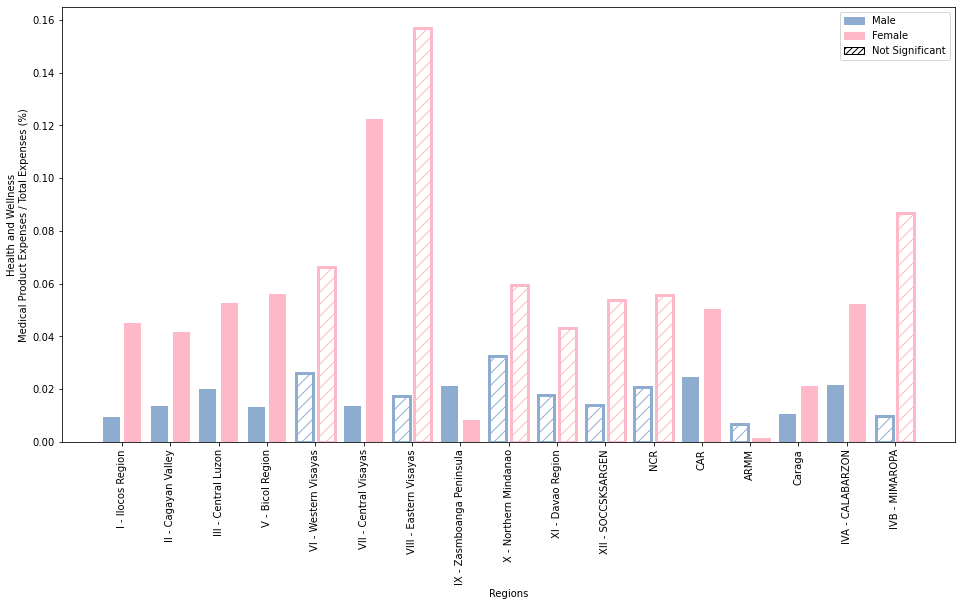

In [578]:
df_hw_reg_diff = pd.read_csv('df_hw_reg_diff.csv')
new_df = pd.read_csv('new_df_hw.csv')

width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = new_df[new_df.sex == 1]
df_f = new_df[new_df.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.med_products_pcntg, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.med_products_pcntg, width, label = 'Women')
ax.set(xticks=x, xticklabels=list(W_REGN.values()))
plt.xticks(rotation=90)
signif = df_hw_reg_diff.med_products_pcntg
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")
        
plt.ylabel('Health and Wellness\nMedical Product Expenses / Total Expenses (%)')
plt.xlabel('Regions')

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass

##### Misc. Expenses

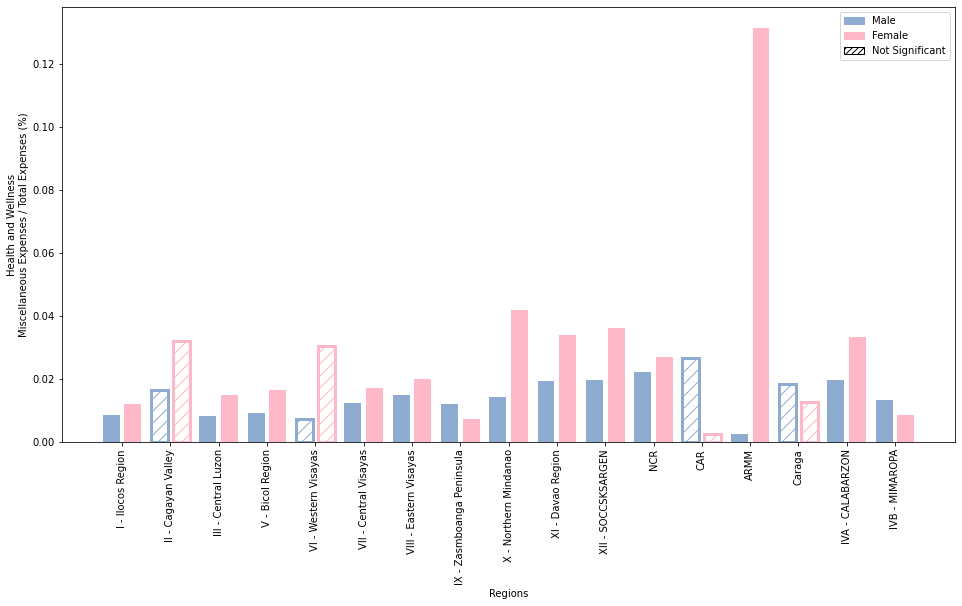

In [579]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = new_df[new_df.sex == 1]
df_f = new_df[new_df.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.hw_misc_pcntg, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.hw_misc_pcntg, width, label = 'Women')
ax.set(xticks=x, xticklabels=list(W_REGN.values()))
plt.xticks(rotation=90)
signif = df_hw_reg_diff.hw_misc_pcntg
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")

plt.ylabel('Health and Wellness\nMiscellaneous Expenses / Total Expenses (%)')
plt.xlabel('Regions')

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass

### Misc. Expenses

#### Entire

In [549]:
pcntg_cols = ['spec_expense_pcntg', 
              'fashion_misc_pcntg']
for pc in pcntg_cols:
    male = df_misc[df_misc.sex == 1][pc]
    female = df_misc[df_misc.sex == 2][pc]
    print(pc,test_for_signif_diff(male, female))

spec_expense_pcntg is probably statistically different per mann-whitney
fashion_misc_pcntg is probably NOT statistically different per mann-whitney


In [561]:
pcntg_cols = ['spec_expense_pcntg',
              'fashion_misc_pcntg']
df_misc_entire = df_misc.groupby('sex')[pcntg_cols].mean().reset_index().melt(id_vars=['sex'])
df_misc_entire.to_csv('df_misc_entire.csv',index = False)

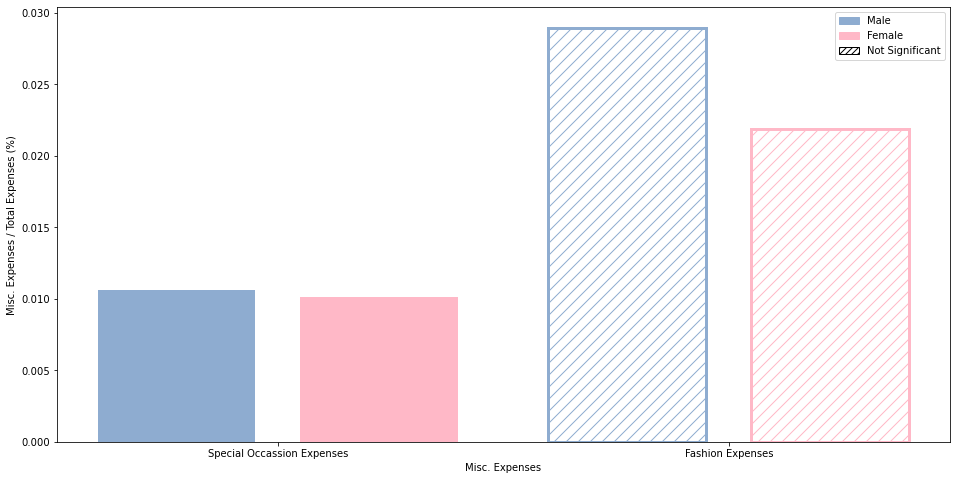

In [580]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = df_misc_entire[df_misc_entire.sex == 1]
df_f = df_misc_entire[df_misc_entire.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.value, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.value, width, label = 'Women')
ax.set(xticks=x, xticklabels=['Special Occassion Expenses', 'Fashion Expenses'])
signif = ['Significant', 'NOT significant']
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")
        
plt.ylabel('Misc. Expenses / Total Expenses (%)')
plt.xlabel('Misc. Expenses')

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass

#### Per Region

In [565]:
pcntg_cols = ['spec_expense_pcntg', 'gadget_expense_pcntg', 'fashion_misc_pcntg']
df_misc_reg_diff = pd.DataFrame()
df_misc_reg_diff['Regn'] = sorted(set(df_misc.w_regn))
df_misc_reg_diff['Regn'] = df_misc_reg_diff['Regn'].map(W_REGN)
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_misc.w_regn)):
        df_reg = df_misc[df_misc['w_regn'] == rgn]
        if 'NOT' in test_for_normality(df_reg[pc]):
            normal = False
        else:
            normal = True
        male = df_reg[df_reg.sex == 1][pc]
        female = df_reg[df_reg.sex == 2][pc]
        test = test_for_signif_diff(male, female, normal)
        if 'NOT' in test:
            test_vals.append('NOT significant')
        else:
            test_vals.append('Significant')
    df_misc_reg_diff[pc] = test_vals
df_misc_reg_diff.to_csv('df_misc_reg_diff.csv',index = False)

/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [563]:
new_df2 = df_misc.groupby(['w_regn','sex'])['spec_expense_pcntg', 'gadget_expense_pcntg', 'fashion_misc_pcntg'].mean().reset_index()
new_df2.to_csv('new_df_misc.csv',index = False)

##### Special Occasion Expenses

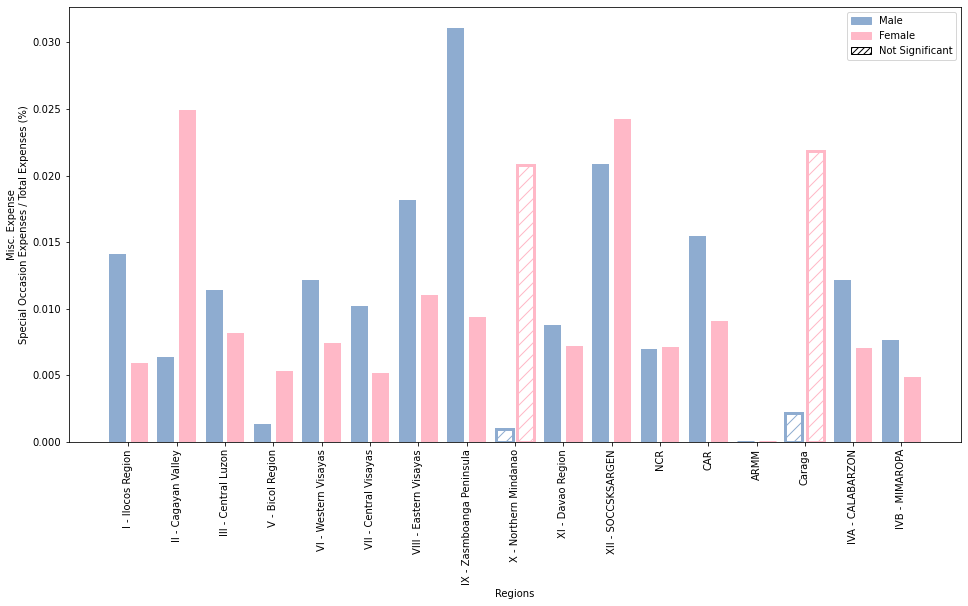

In [581]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = new_df2[new_df2.sex == 1]
df_f = new_df2[new_df2.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.spec_expense_pcntg, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.spec_expense_pcntg, width, label = 'Women')
ax.set(xticks=x, xticklabels=list(W_REGN.values()))
plt.xticks(rotation=90)
signif = df_misc_reg_diff.spec_expense_pcntg
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")

plt.ylabel('Misc. Expense\nSpecial Occasion Expenses / Total Expenses (%)')
plt.xlabel('Regions')

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass

##### Gadget Expenses

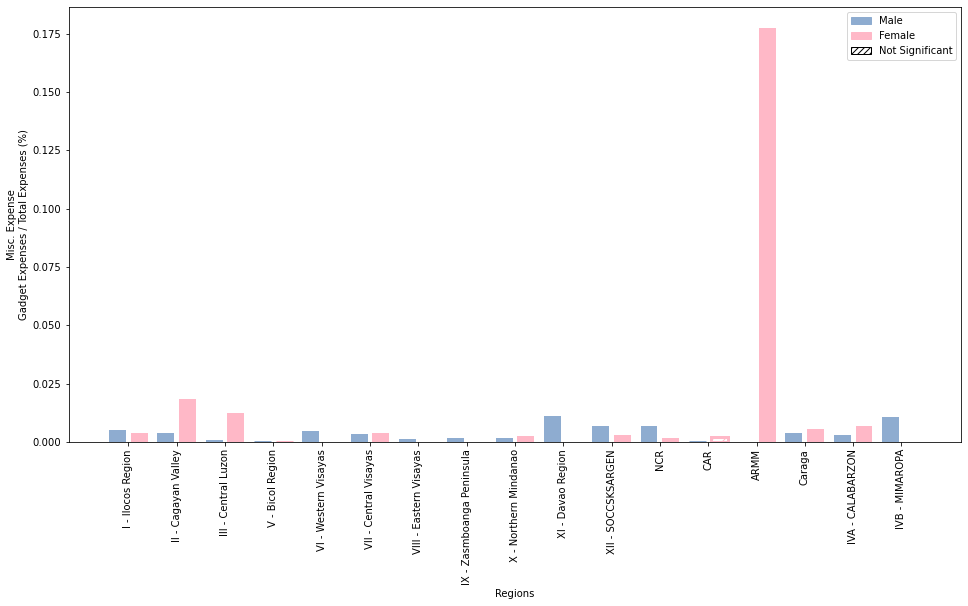

In [582]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = new_df2[new_df2.sex == 1]
df_f = new_df2[new_df2.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.gadget_expense_pcntg, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.gadget_expense_pcntg, width, label = 'Women')
ax.set(xticks=x, xticklabels=list(W_REGN.values()))
plt.xticks(rotation=90)
signif = df_misc_reg_diff.gadget_expense_pcntg
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")

plt.ylabel('Misc. Expense\nGadget Expenses / Total Expenses (%)')
plt.xlabel('Regions')

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass

##### Fashion Expenses

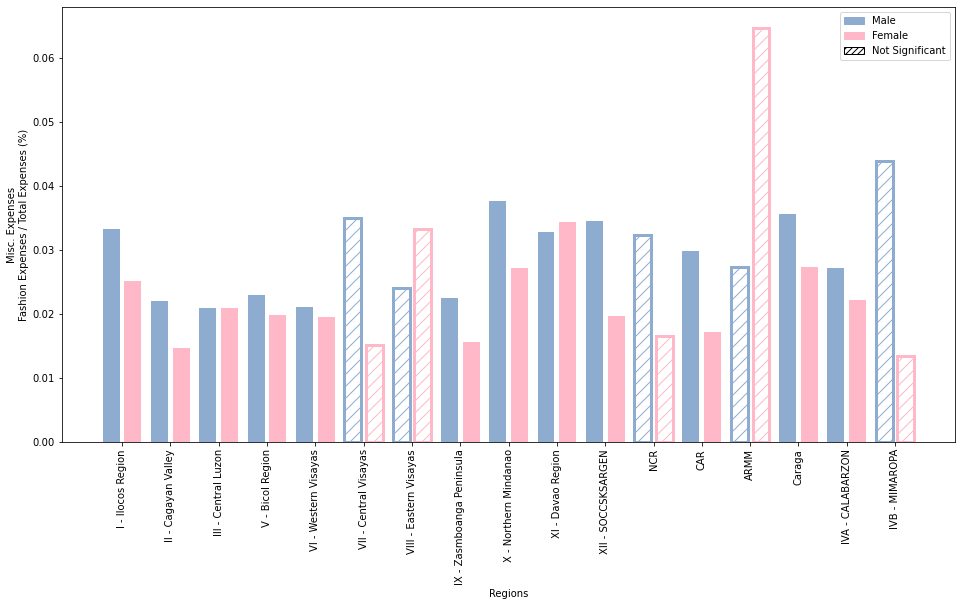

In [583]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = new_df2[new_df2.sex == 1]
df_f = new_df2[new_df2.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.fashion_misc_pcntg, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.fashion_misc_pcntg, width, label = 'Women')
ax.set(xticks=x, xticklabels=list(W_REGN.values()))
plt.xticks(rotation=90)
signif = df_misc_reg_diff.fashion_misc_pcntg
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")

plt.ylabel('Misc. Expenses\nFashion Expenses / Total Expenses (%)')
plt.xlabel('Regions')

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass

### Impersonal Expenses

#### Entire

In [562]:
pcntg_cols = ['donations_expense_pcntg']
df_impr_entire = df_impr.groupby('sex')[pcntg_cols].mean().reset_index().melt(id_vars=['sex'])
df_impr_entire.to_csv('df_impr_entire.csv',index = False)

In [544]:
for pc in pcntg_cols:
    male = df_impr[df_impr.sex == 1][pc]
    female = df_impr[df_impr.sex == 2][pc]
    print(pc,test_for_signif_diff(male, female))

donations_expense_pcntg is probably NOT statistically different per mann-whitney


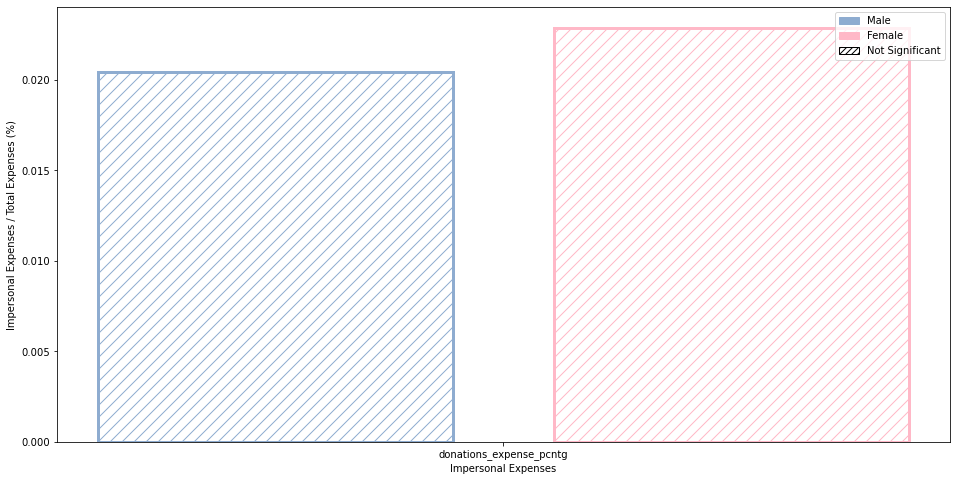

In [584]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = df_impr_entire[df_impr_entire.sex == 1]
df_f = df_impr_entire[df_impr_entire.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.value, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.value, width, label = 'Women')
ax.set(xticks=x, xticklabels=['donations_expense_pcntg'])
signif = ['NOT significant']
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")
        
plt.ylabel('Impersonal Expenses / Total Expenses (%)')
plt.xlabel('Impersonal Expenses')

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass

#### Per Region

In [566]:
pcntg_cols = ['donations_expense_pcntg']
df_impr_reg_diff = pd.DataFrame()
df_impr_reg_diff['Regn'] = sorted(set(df_impr.w_regn))
df_impr_reg_diff['Regn'] = df_impr_reg_diff['Regn'].map(W_REGN)
for pc in pcntg_cols:
    test_vals = []
    for rgn in sorted(set(df_impr.w_regn)):
        df_reg = df_impr[df_impr['w_regn'] == rgn]
        if 'NOT' in test_for_normality(df_reg[pc]):
            normal = False
        else:
            normal = True
        male = df_reg[df_reg.sex == 1][pc]
        female = df_reg[df_reg.sex == 2][pc]
        test = test_for_signif_diff(male, female, normal)
        if 'NOT' in test:
            test_vals.append('NOT significant')
        else:
            test_vals.append('Significant')
    df_impr_reg_diff[pc] = test_vals
df_impr_reg_diff.to_csv('df_impr_reg_diff.csv',index = False)

In [564]:
new_df3 = df_impr.groupby(['w_regn','sex'])['donations_expense_pcntg'].mean().reset_index()
new_df3.to_csv('new_df_impr.csv',index = False)

##### Donations

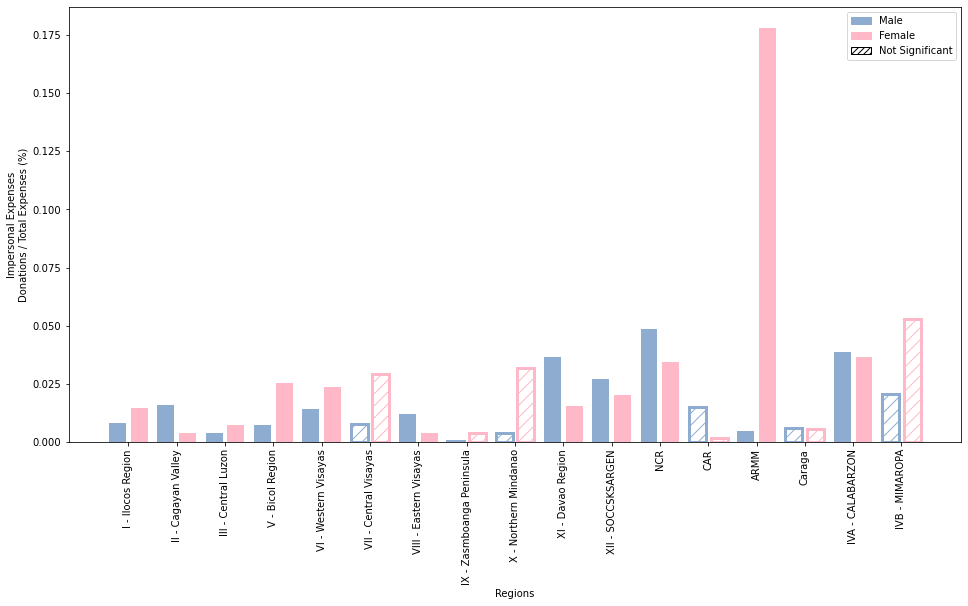

In [585]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (16,8))

df_m = new_df3[new_df3.sex == 1]
df_f = new_df3[new_df3.sex == 2]
x = np.arange(len(df_m))
p1 = ax.bar(x - width/2 - 0.05, df_m.donations_expense_pcntg, width, label = 'Men')
p2 = ax.bar(x + width/2 + 0.05, df_f.donations_expense_pcntg, width, label = 'Women')
ax.set(xticks=x, xticklabels=list(W_REGN.values()))
plt.xticks(rotation=90)
signif = df_impr_reg_diff.donations_expense_pcntg
for i in range(len(p1)):
    if signif[i] == 'NOT significant':
        p1[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#8eacd0")
        p2[i].set(fill=False, linewidth = 3, hatch = '//', edgecolor = "#ffb8c7")

plt.ylabel('Impersonal Expenses\nDonations / Total Expenses (%)')
plt.xlabel('Regions')

legend_elements = [Patch(facecolor="#8eacd0", edgecolor="#8eacd0",
                         label='Male'),
                   Patch(facecolor="#ffb8c7", edgecolor="#ffb8c7",
                         label='Female'),
                   Patch(fill=False, linewidth = 1, hatch = '////',
                         edgecolor = "k",
                         label = 'Not Significant')]
ax.legend(handles=legend_elements, loc='upper right')
pass